In [1]:
### Activation of necessary modules

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

#### Setting plotting and display options

np.set_printoptions(precision = 3)

pd.set_option("precision", 3)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

In [2]:
start = dt.datetime(2002, 11, 1)
end = dt.datetime(2021, 10, 31)

In [3]:
SP500 = pdr.get_data_yahoo("^GSPC",
                            start = start,
                            end = end
                            ).dropna()
SP500.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-10-25,4572.620,4537.360,4553.690,4566.480,3250210000,4566.480
2021-10-26,4598.530,4569.170,4578.690,4574.790,2866500000,4574.790
2021-10-27,4584.570,4551.660,4580.220,4551.680,3259510000,4551.680
2021-10-28,4597.550,4562.840,4562.840,4596.420,3197560000,4596.420
2021-10-29,4608.080,4567.590,4572.870,4605.380,3632260000,4605.380


In [4]:
closing_prices = SP500[["Adj Close"]]

In [5]:
closing_prices.head()

,Adj Close
Date,
2002-10-31,885.760
2002-11-01,900.960
2002-11-04,908.350
2002-11-05,915.390
2002-11-06,923.760


In [6]:
closing_prices.isna().sum()

Adj Close    0
dtype: int64

### `Momentum` Strategy

In [7]:
MS = closing_prices.copy()
MS = MS.rename(columns = {'Adj Close': 'Price'})

MS['RETURNS'] = np.log(MS['Price'] / MS['Price'].shift(1))
short = 20
long = 60
MS['SMA_S'] = MS['Price'].rolling(short, 
                                 min_periods = 1, 
                                 center = False).mean()
MS['SMA_L'] = MS['Price'].rolling(long, 
                                 min_periods = 1, 
                                 center = False).mean()
MS.dropna(inplace = True)

MS['trading_position'] = np.where(MS['SMA_S'] < MS['SMA_L'], 
                         -1, 1)

In [8]:
MS['buy_or_sell'] = 0
MS['buy_or_sell'][short:] = np.where(MS['SMA_S'][short:] > MS['SMA_L'][short:], 
                                    1.0, 0)
MS['position'] = MS['buy_or_sell'].diff()

<ipython-input-8-40ce4400fe98>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MS['buy_or_sell'][short:] = np.where(MS['SMA_S'][short:] > MS['SMA_L'][short:],


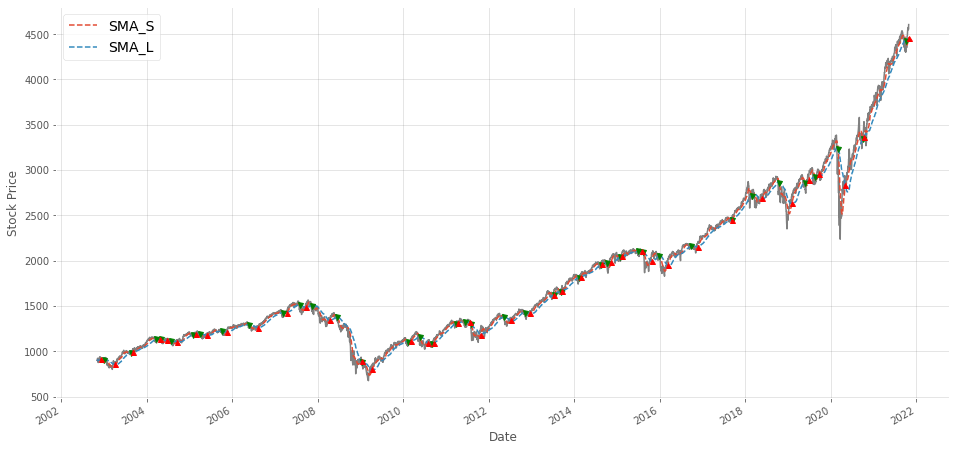

In [9]:
fig = plt.figure(figsize = (16, 8))
sub = fig.add_subplot(111, 
                     ylabel = 'Stock Price')

MS['Price'].plot(ax = sub, 
                color = 'grey')
MS[['SMA_S', 'SMA_L']].plot(ax = sub, 
                           style = ['--', 
                                   '--']
                           )
sub.plot(MS.loc[MS.position == -1.0].index, 
        MS.SMA_S.loc[MS.position == -1.0], 
        'v', 
         markersize = 5,
        color = 'green')
sub.plot(MS.loc[MS.position == 1.0].index, 
        MS.SMA_S.loc[MS.position == 1.0], 
        '^', 
        markersize = 5, 
        color = 'red')
plt.show()

##### Backtesting

In [10]:
capital = float(500000.0)

position = pd.DataFrame(index = MS.index).fillna(0.0)
position['SPY'] = (capital // MS.Price[0]) * MS['buy_or_sell']

portfolio = position.multiply(MS['Price'], 
                                    axis = 0)

diff_in_shares_owned = position.diff()

portfolio['holdings'] = position.multiply(MS['Price'], 
                                         axis = 0).sum(axis = 1)

portfolio['cash'] = capital - diff_in_shares_owned.multiply(MS['Price'], 
                                                           axis = 0).sum(axis = 1).cumsum()

portfolio['total'] = portfolio['holdings'] + portfolio['cash']
portfolio['return'] = portfolio['total'].pct_change()

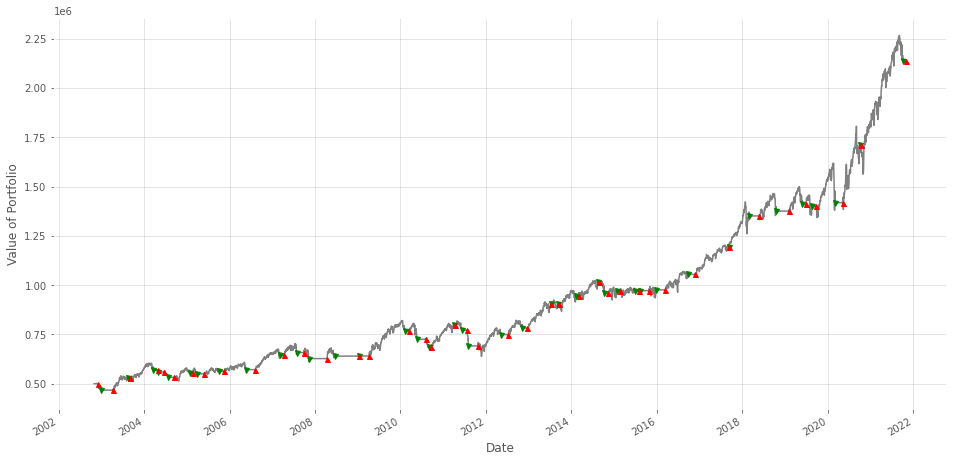

In [11]:
fig = plt.figure(figsize = (16, 8))

sub = fig.add_subplot(111,
                      ylabel = "Value of Portfolio")

portfolio["total"].plot(ax = sub, 
                            color = "grey")


sub.plot(portfolio.loc[MS.position == -1.0].index,
         portfolio.total[MS.position == -1.0],
         "v",
         color = "green",
         markersize = 5)

# Plot "buy trades"
sub.plot(portfolio.loc[MS.position == 1.0].index,
         portfolio.total[MS.position == 1.0],
         "^",
         color = "red",
         markersize = 5)

plt.show()

##### Performance Metrix

In [12]:
Returns = portfolio['return']
Sharpe = np.sqrt(Returns.mean() / Returns.std())
Sharpe

0.20974194035058777

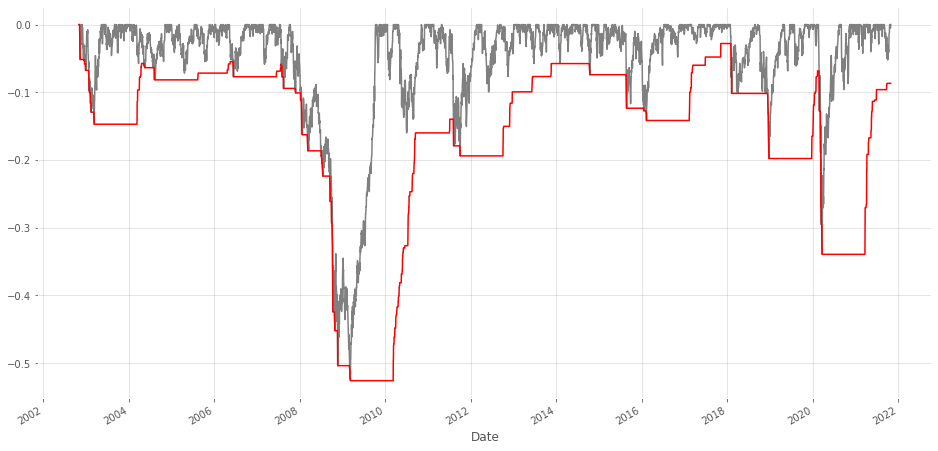

In [13]:
window = 253
rolling_max_drawdown = MS['Price'].rolling(window, 
                                          min_periods = 1).max()
drawdown_daily = MS['Price'] / rolling_max_drawdown - 1.0
max_drawdown = drawdown_daily.rolling(window, 
                                     min_periods = 1).min()

fig = plt.figure(figsize = (16, 8)
                )
drawdown_daily.plot(color = 'grey')
max_drawdown.plot(color = 'red')
plt.show()

In [14]:
D = (portfolio.index[0] - portfolio.index[-1]).days

CAGR_MS = np.exp(portfolio['return'].sum()) ** (365.0 / D) - 1

CAGR_MS

-0.0803118309541363

### `Mean Reversion` Strategy

#### windows from 5 days to 120 days, weekly based

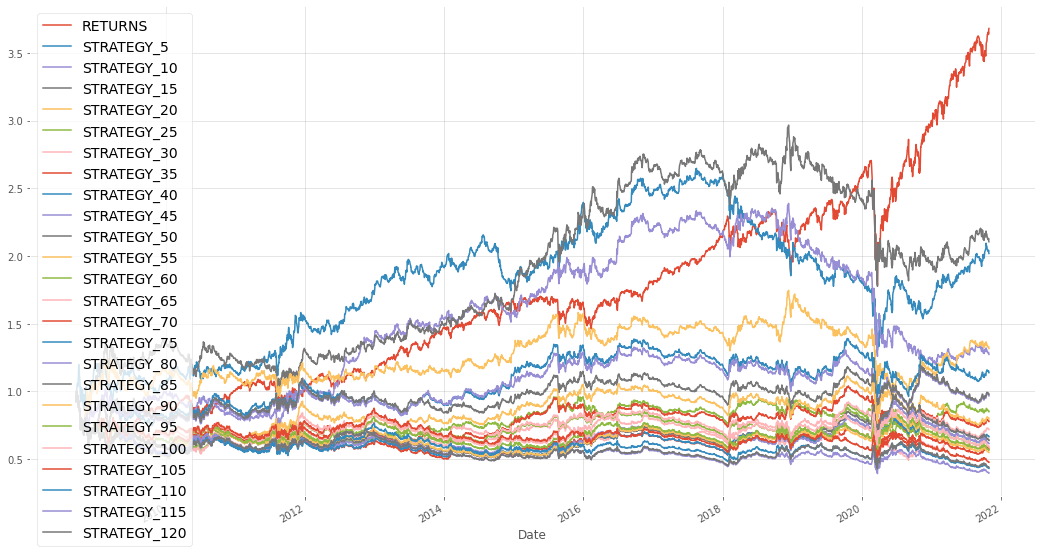

In [7]:
MR = closing_prices.copy().rename(columns = {'Adj Close': 'Price'})

MR['RETURNS'] = np.log(MR['Price'] / MR['Price'].shift(1)
                      )
    
windows = np.arange(0, 125, 5)

list_for_plot = ['RETURNS']
exceed = []
for w in windows[1:]:

    MR['SMA_R'] = MR['Price'].rolling(w).mean()

    #defince threshold as moving standand deviation of price
    MR['Std_Dev'] = MR['Price'].rolling(w).std()
    MR['DIST'] = MR['Price'] - MR['SMA_R']
    MR.dropna(inplace = True)

    #MR['DIST'].plot(figsize = (20, 8)
     #          )
    #plt.show()
    
    MR['POSITION_%d' %w] = np.where(MR['DIST'] > MR['Std_Dev'], 
                         -1, np.nan
                         )
    MR['POSITION_%d' %w] = np.where(MR['DIST'] < -MR['Std_Dev'], 
                         1, MR['POSITION_%d' %w]
                         )
    MR['POSITION_%d' %w] = np.where(MR['DIST'] * MR['DIST'] < 0, 
                         0, MR['POSITION_%d' %w]
                         )

    MR['POSITION_%d' %w] = MR['POSITION_%d' %w].ffill()
    MR['POSITION_%d' %w] = MR['POSITION_%d' %w].fillna(0)
    
    MR['STRATEGY_%d' %w] = MR['POSITION_%d' %w].shift(1) * MR['RETURNS']
    
    list_for_plot.append('STRATEGY_%d' %w)
    exceed.append(MR[['STRATEGY_%d' %w]].dropna().sum().apply(np.exp)[0] - MR[['RETURNS']].dropna().sum().apply(np.exp)[0])
    
MR[list_for_plot].dropna().cumsum().apply(np.exp).plot(figsize = (18, 10))
plt.show()

In [8]:
excess_return = MR[list_for_plot].dropna().sum(axis = 0).apply(np.exp)[1:].max() - MR[['RETURNS']].dropna().sum().apply(np.exp)[0]

In [9]:
returns = MR[list_for_plot].dropna().sum(axis = 0).apply(np.exp)[1:]

In [10]:
print('Max Strategy is ', str(returns[returns == max(returns)].index[0]), ' with excess return of ', str(excess_return))

Max Strategy is  STRATEGY_15  with excess return of  -1.5822100344145476


In [11]:
MR[['STRATEGY_15']].dropna().sum().apply(np.exp)[0]

2.109361536950739

##### Strategy of 15 days moving avarage

In [12]:
MR['POSITION_15'].value_counts()

-1.000    2113
1.000     1194
Name: POSITION_15, dtype: int64

In [13]:
MR['buy_or_sell'] = np.where(MR['POSITION_15'] == 1.0, 
                       1, 0) 
MR['SIGNAL'] = MR['buy_or_sell'].diff()

In [14]:
MR['SIGNAL'].value_counts()

0.000     3105
-1.000     101
1.000      100
Name: SIGNAL, dtype: int64

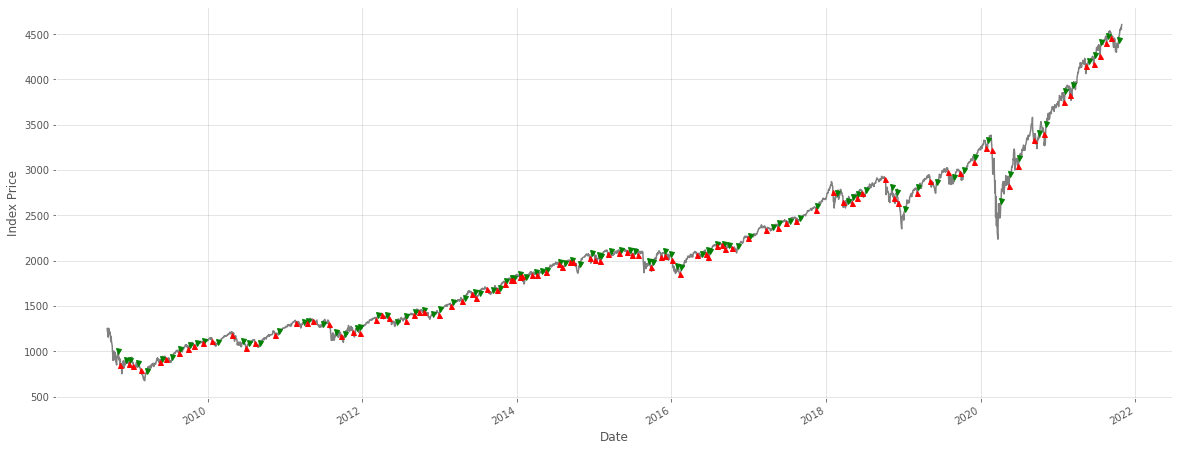

In [15]:
fig = plt.figure(figsize = (20, 8))

sub = fig.add_subplot(111, 
                     ylabel = 'Index Price')

MR['Price'].plot(ax = sub, 
                color = 'grey')

sub.plot(MR.loc[MR['SIGNAL'] == -1].index, 
        MR.Price[MR['SIGNAL'] == -1], 
        'v', 
        markersize = 5,
        color = 'green')

sub.plot(MR.loc[MR['SIGNAL'] == 1].index, 
        MR.Price[MR['SIGNAL'] == 1], 
        '^', 
        markersize = 5, 
        color = 'red')
plt.show()

##### Backtesting

In [16]:
capital = float(500000.0)

In [17]:
MRposition = pd.DataFrame(index = MR.index).fillna(0.0)
MRposition['SP500'] = (capital // MR['Price'][0]) * MR['buy_or_sell']
MRportfolio = MRposition.multiply(MR['Price'], 
                                             axis = 0)
diff_in_share_owned = MRposition.diff()

MRportfolio['holdings'] = (MRposition.multiply(MR['Price'], 
                                                           axis = 0)
                          ).sum(axis = 1)
MRportfolio['cash'] = capital - (diff_in_share_owned.multiply(MR['Price'], 
                                                                           axis = 0)).sum(axis = 1).cumsum()
MRportfolio['total'] = MRportfolio['holdings'] + MRportfolio['cash']
MRportfolio['returns'] = MRportfolio['total'].pct_change()

In [18]:
MRportfolio_final_value = MRportfolio.total[-1]
print('Final Value of Capital is ', str(MRportfolio_final_value))

Final Value of Capital is  1856862.8909301758


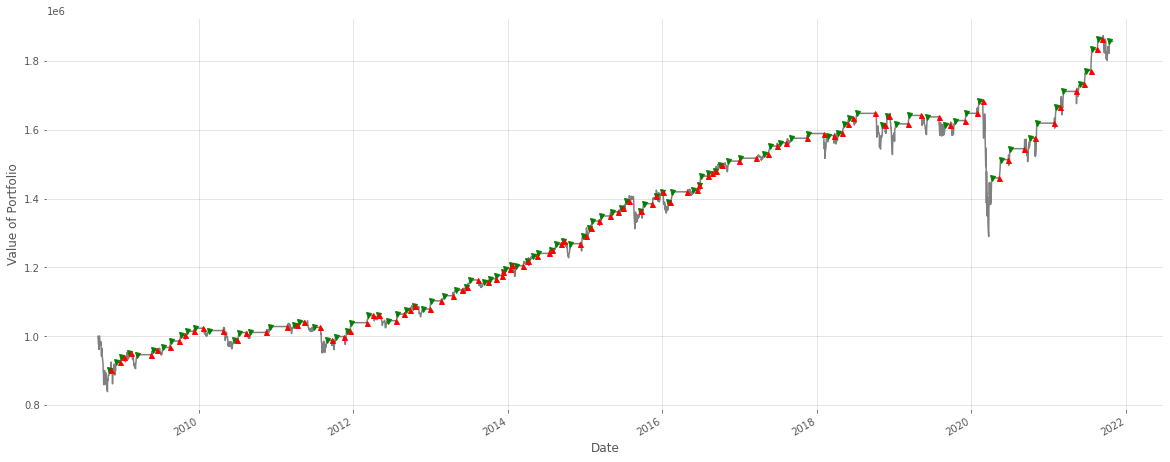

In [19]:
fig = plt.figure(figsize = (20, 8))
sub = fig.add_subplot(111, 
                     ylabel = 'Value of Portfolio')
MRportfolio['total'].plot(ax = sub, 
                         color = 'grey')
sub.plot(MRportfolio.loc[MR['SIGNAL'] == -1].index, 
        MRportfolio.total[MR['SIGNAL'] == -1], 
        'v', 
        color = 'green', 
        markersize = 5)
sub.plot(MRportfolio.loc[MR['SIGNAL'] == 1].index, 
        MRportfolio.total[MR['SIGNAL'] == 1], 
        '^', 
        color = 'red', 
        markersize = 5)

In [20]:
Sharpe = np.sqrt(253) * (MRportfolio['returns'].mean() / MRportfolio['returns'].std())
Sharpe

0.5323914329635493

In [21]:
D = (MRportfolio.index[-1] - MRportfolio.index[0]).days

CAGR = (MRportfolio[['returns']].sum().apply(np.exp) ** (365.0/D)) -1
CAGR

returns   0.053
dtype: float64

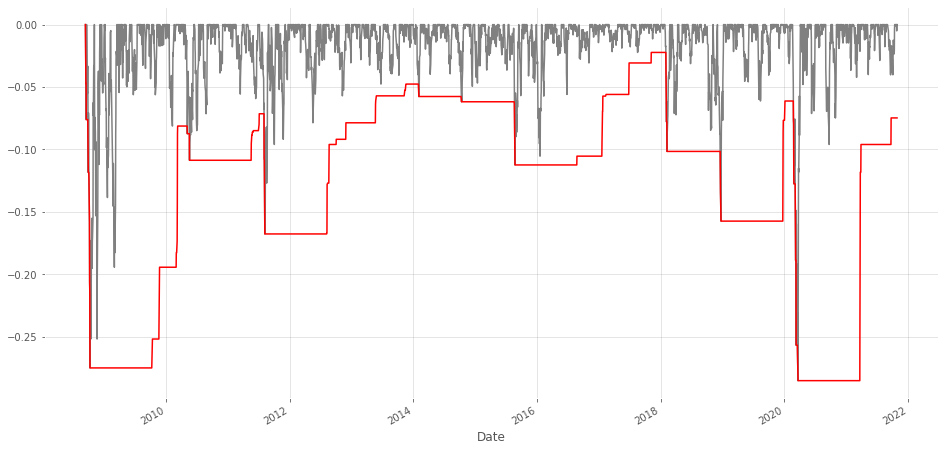

In [22]:
rolling_max_drawdown = MR["Price"].rolling(window = 15,
                                               min_periods = 1).max() 

drawdown_daily = MR["Price"] / rolling_max_drawdown - 1.0 

max_drawdown_daily = drawdown_daily.rolling(window = 253,
                                            min_periods = 1).min() 

fig = plt.figure(figsize = (16,8)
                 )

drawdown_daily.plot(color = "grey")
max_drawdown_daily.plot(color = "red") 

plt.show()

#### Intraday Mean Reversion

##### Intraday Trading with rolling minutes (past 7 days)

In [23]:
IntraMR = yf.download(tickers = 'SPY', 
                start = dt.datetime.strptime('2021-10-31', '%Y-%m-%d') - dt.timedelta(7), 
                end = end,
                interval = '1m', 
                auto_adjust = True).dropna()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SPY: 1m data not available for startTime=1635004800 and endTime=1635609600. The requested range must be within the last 30 days.


In [24]:
IntraMR = IntraMR[['Close']].rename(columns = {'Close': 'Price'})
IntraMR['RETURNS'] = np.log(IntraMR['Price'] / IntraMR['Price'].shift(1)
                           )
IntraMR.dropna(inplace = True)

In [25]:
intra_list = ['RETURNS']
intra_exceed = []
N = np.arange(1, 240, 1)
for n in N:
    IntraMR['SMA_R'] = IntraMR['Price'].rolling(n).mean()
    IntraMR['Std_Dev'] = IntraMR['Price'].rolling(n).std()
    IntraMR['DIST'] = IntraMR['Price'] - IntraMR['SMA_R']
    #IntraMR.dropna(inplace = True)
    
    IntraMR['POSITION_%d' %n] = np.where(IntraMR['DIST'] > IntraMR['Std_Dev'], 
                         -1, np.nan
                         )
    IntraMR['POSITION_%d' %n] = np.where(IntraMR['DIST'] < -IntraMR['Std_Dev'], 
                         1, IntraMR['POSITION_%d' %n]
                         )
    IntraMR['POSITION_%d' %n] = np.where(IntraMR['DIST'] * IntraMR['DIST'] < 0, 
                         0, IntraMR['POSITION_%d' %n]
                         )

    IntraMR['POSITION_%d' %n] = IntraMR['POSITION_%d' %n].ffill()
    IntraMR['POSITION_%d' %n] = IntraMR['POSITION_%d' %n].fillna(0)
    
    IntraMR['STRATEGY_%d' %n] = IntraMR['POSITION_%d' %n].shift(1) * IntraMR['RETURNS']
    
    intra_list.append('STRATEGY_%d' %n)
    intra_exceed.append(IntraMR[['STRATEGY_%d' %n]].dropna().sum().apply(np.exp)[0] - IntraMR[['RETURNS']].dropna().sum().apply(np.exp)[0])
#IntraMR[intra_list].cumsum().apply(np.exp).plot(figsize = (18, 10))
#plt.show()

In [26]:
print('Max Strategy is ', str(intra_list[intra_exceed.index(max(intra_exceed)) + 1]), ' with excess return of ', str(max(intra_exceed)))

Max Strategy is  STRATEGY_1  with excess return of  0.0


In [27]:
IntraMR[['STRATEGY_210']].dropna().sum().apply(np.exp)

STRATEGY_210   1.000
dtype: float64

#### Intraday Trading with rolling hours (past 708 days)

In [34]:
IntraMR = yf.download(tickers = 'SPY', 
                start = dt.datetime.strptime('2022-01-10', '%Y-%m-%d') - dt.timedelta(708), 
                end = end,
                interval = '1h', 
                auto_adjust = True).dropna()

[*********************100%***********************]  1 of 1 completed


In [35]:
IntraMR = IntraMR[['Close']].rename(columns = {'Close': 'Price'})
IntraMR['RETURNS'] = np.log(IntraMR['Price'] / IntraMR['Price'].shift(1)
                           )
IntraMR.dropna(inplace = True)
IntraMR

,Price,RETURNS
2020-02-03 10:30:00-05:00,324.690,-0.004
2020-02-03 11:30:00-05:00,324.560,-0.000
2020-02-03 12:30:00-05:00,324.210,-0.001
2020-02-03 13:30:00-05:00,324.290,0.000
2020-02-03 14:30:00-05:00,324.950,0.002
...,...,...
2021-10-29 11:30:00-04:00,459.140,0.002
2021-10-29 12:30:00-04:00,458.850,-0.001
2021-10-29 13:30:00-04:00,457.830,-0.002
2021-10-29 14:30:00-04:00,457.905,0.000


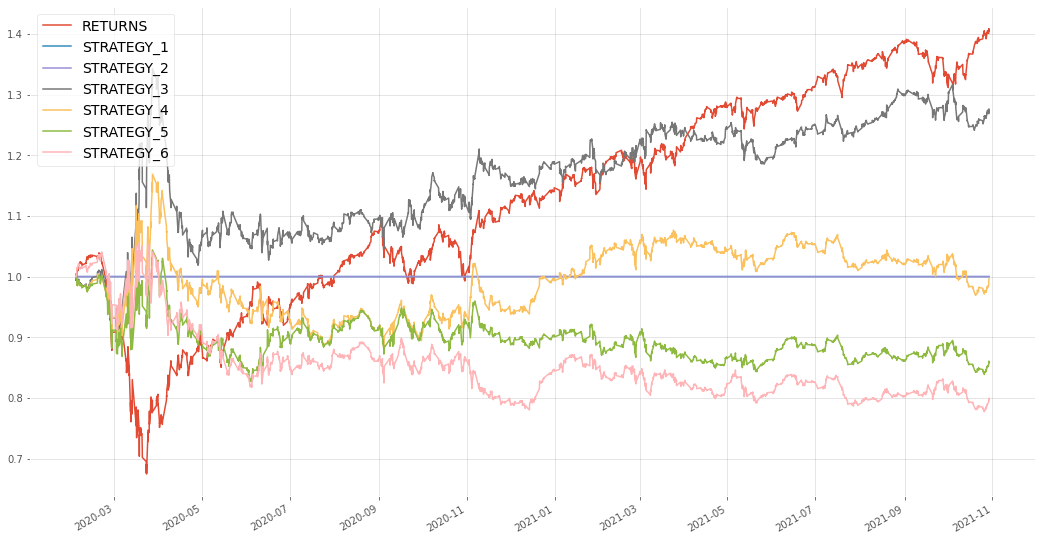

In [36]:
intra_list = ['RETURNS']
intra_exceed = []
N = np.arange(1, 7, 1)
for n in N:
    IntraMR['SMA_R'] = IntraMR['Price'].rolling(n).mean()
    IntraMR['Std_Dev'] = IntraMR['Price'].rolling(n).std()
    IntraMR['DIST'] = IntraMR['Price'] - IntraMR['SMA_R']
    #IntraMR.dropna(inplace = True)
    
    IntraMR['POSITION_%d' %n] = np.where(IntraMR['DIST'] > IntraMR['Std_Dev'], 
                         -1, np.nan
                         )
    IntraMR['POSITION_%d' %n] = np.where(IntraMR['DIST'] < -IntraMR['Std_Dev'], 
                         1, IntraMR['POSITION_%d' %n]
                         )
    IntraMR['POSITION_%d' %n] = np.where(IntraMR['DIST'] * IntraMR['DIST'] < 0, 
                         0, IntraMR['POSITION_%d' %n]
                         )

    IntraMR['POSITION_%d' %n] = IntraMR['POSITION_%d' %n].ffill()
    IntraMR['POSITION_%d' %n] = IntraMR['POSITION_%d' %n].fillna(0)
    
    IntraMR['STRATEGY_%d' %n] = IntraMR['POSITION_%d' %n].shift(1) * IntraMR['RETURNS']
    
    intra_list.append('STRATEGY_%d' %n)
    intra_exceed.append(IntraMR[['STRATEGY_%d' %n]].dropna().sum().apply(np.exp)[0] - IntraMR[['RETURNS']].dropna().sum().apply(np.exp)[0])
IntraMR[intra_list].cumsum().apply(np.exp).plot(figsize = (18, 10))
plt.show()

#fig = plt.figure(figsize = (18, 10))
#plt.plot(IntraMR.index, IntraMR['RETURNS'].cumsum().apply(np.exp), color = 'r', lw = 2, label = 'RETURNS')
#plt.plot(IntraMR.index, IntraMR[intra_list].cumsum().apply(np.exp), lw = 0.8, alpha = 0.8, label = intra_list)
#plt.legend()
#plt.show()

In [37]:
print('Max Strategy is ', str(intra_list[intra_exceed.index(max(intra_exceed)) + 1]), ' with excess return of ', str(max(intra_exceed)))

Max Strategy is  STRATEGY_3  with excess return of  -0.13224717970082733


In [38]:
IntraMR[['STRATEGY_3']].dropna().sum().apply(np.exp)

STRATEGY_3   1.276
dtype: float64

##### Strategy of 3 hours moving avarage (ONE DAY RETURN)

In [39]:
IntraMR['buy_or_sell'] = np.where(IntraMR['POSITION_3'] == 1.0, 
                       1, 0) 
IntraMR['SIGNAL'] = IntraMR['buy_or_sell'].diff()

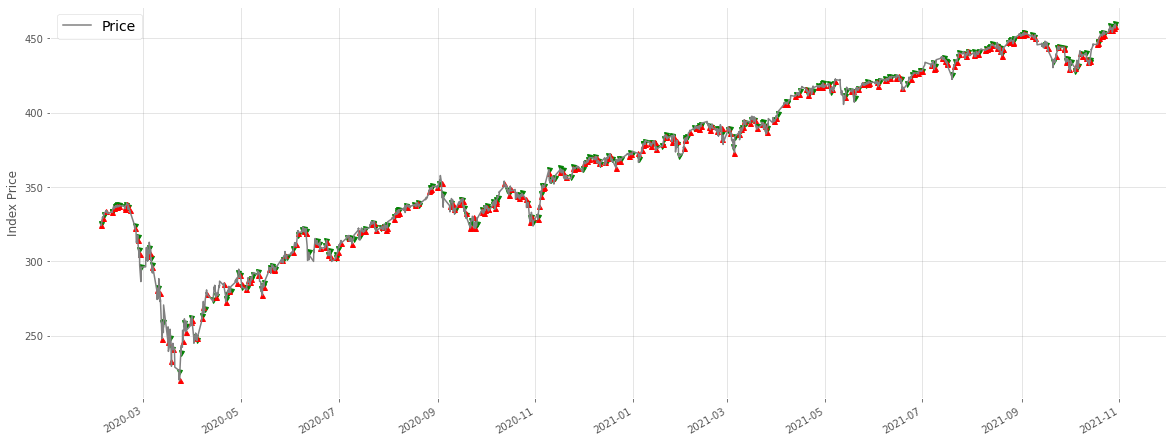

In [40]:
fig = plt.figure(figsize = (20, 8))

sub = fig.add_subplot(111, 
                     ylabel = 'Index Price')

sub.plot(IntraMR.loc[IntraMR['SIGNAL'] == -1].index, 
        IntraMR.Price[IntraMR['SIGNAL'] == -1], 
        'v', 
        markersize = 5,
        color = 'green')

sub.plot(IntraMR.loc[IntraMR['SIGNAL'] == 1].index, 
        IntraMR.Price[IntraMR['SIGNAL'] == 1], 
        '^', 
        markersize = 5, 
        color = 'red')
IntraMR[['Price']].plot(ax = sub, 
                color = 'grey')
plt.show()

##### Backtesting

In [41]:
IntraMRposition = pd.DataFrame(index = IntraMR.index).fillna(0.0)
IntraMRposition['SP500'] = (capital // IntraMR['Price'][0]) * IntraMR['buy_or_sell']
IntraMRportfolio = IntraMRposition.multiply(IntraMR['Price'], 
                                             axis = 0)
diff_in_share_owned = IntraMRposition.diff()

IntraMRportfolio['holdings'] = (IntraMRposition.multiply(IntraMR['Price'], 
                                                           axis = 0)
                          ).sum(axis = 1)
IntraMRportfolio['cash'] = capital - (diff_in_share_owned.multiply(IntraMR['Price'], 
                                                                           axis = 0)).sum(axis = 1).cumsum()
IntraMRportfolio['total'] = IntraMRportfolio['holdings'] + IntraMRportfolio['cash']
IntraMRportfolio['returns'] = IntraMRportfolio['total'].pct_change()

IntraMRportfolio_final_value = IntraMRportfolio.total[-1]
print('Final Value of Capital is ', str(IntraMRportfolio_final_value))

Final Value of Capital is  662840.0833129883


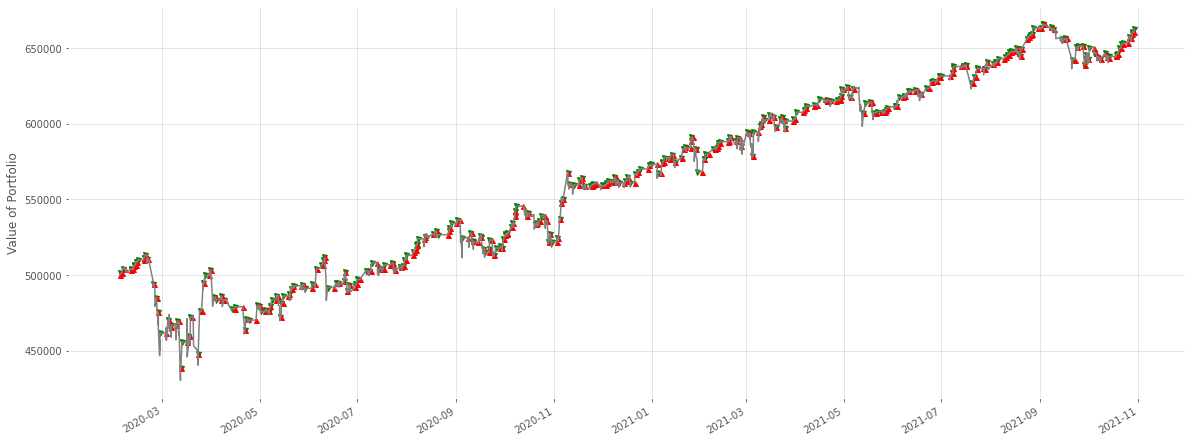

In [42]:
fig = plt.figure(figsize = (20, 8))
sub = fig.add_subplot(111, 
                     ylabel = 'Value of Portfolio')
sub.plot(IntraMRportfolio.loc[IntraMR['SIGNAL'] == -1].index, 
        IntraMRportfolio.total[IntraMR['SIGNAL'] == -1], 
        'v', 
        color = 'green', 
        markersize = 5)
sub.plot(IntraMRportfolio.loc[IntraMR['SIGNAL'] == 1].index, 
        IntraMRportfolio.total[IntraMR['SIGNAL'] == 1], 
        '^', 
        color = 'red', 
        markersize = 5)
IntraMRportfolio['total'].plot(ax = sub, 
                         color = 'grey')
plt.show()

In [43]:
Sharpe = np.sqrt(253) * (IntraMRportfolio['returns'].mean() / IntraMRportfolio['returns'].std())
Sharpe

0.40202827104854516

In [ ]:
#D = (IntraMRportfolio.index[-1] - IntraMRportfolio.index[0]).days

#CAGR = (IntraMRportfolio[['returns']].sum().apply(np.exp) ** (365.0/D)) -1
#CAGR

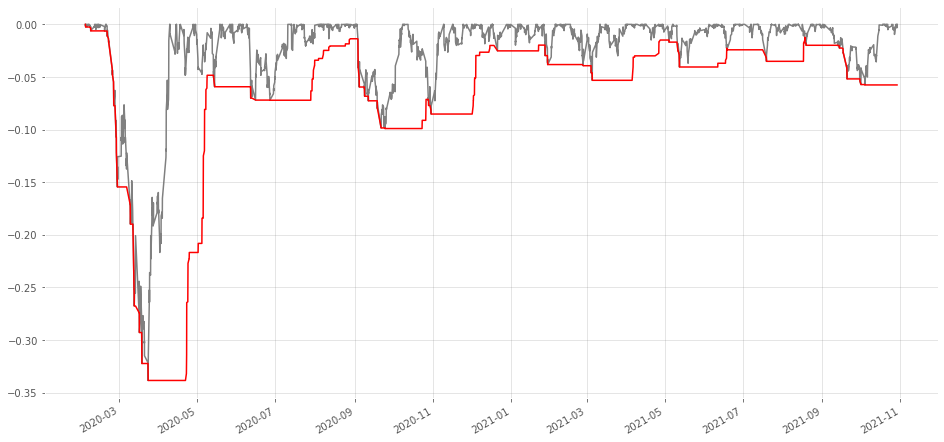

In [44]:
rolling_max_drawdown = IntraMR["Price"].rolling(window = 146,
                                               min_periods = 1).max() 

drawdown_daily = IntraMR["Price"] / rolling_max_drawdown - 1.0 

max_drawdown_daily = drawdown_daily.rolling(window = 146,
                                            min_periods = 1).min() 

fig = plt.figure(figsize = (16,8)
                 )

drawdown_daily.plot(color = "grey")
max_drawdown_daily.plot(color = "red") # This is your focal point of interest here.

plt.show()

#### RSI

In [45]:
import talib

In [46]:
rsi = pd.DataFrame(SP500['Adj Close'], index = SP500.index)
rsi.rename(columns = {'Adj Close': 'Price'}, inplace = True)
rsi['RETURNS'] = np.log(rsi['Price'] / rsi['Price'].shift(1))
rsi['RSI'] = talib.RSI(SP500['Adj Close'])
rsi.dropna(inplace = True)

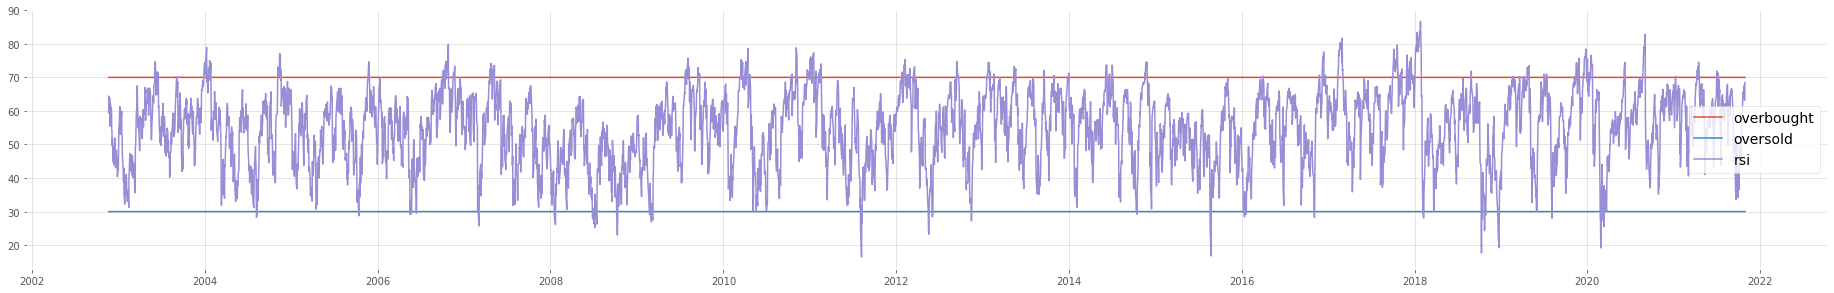

In [47]:
fig = plt.figure()
fig.set_size_inches((25, 18))
ax_rsi = fig.add_axes((0, 0.24, 1, 0.2))
ax_rsi.plot(rsi.index, 
           [70]* len(rsi.index), 
           label = 'overbought')
ax_rsi.plot(rsi.index, 
           [30] * len(rsi.index), 
           label = 'oversold')
ax_rsi.plot(rsi.index, 
            rsi["RSI"], 
           label = 'rsi')

ax_rsi.legend()

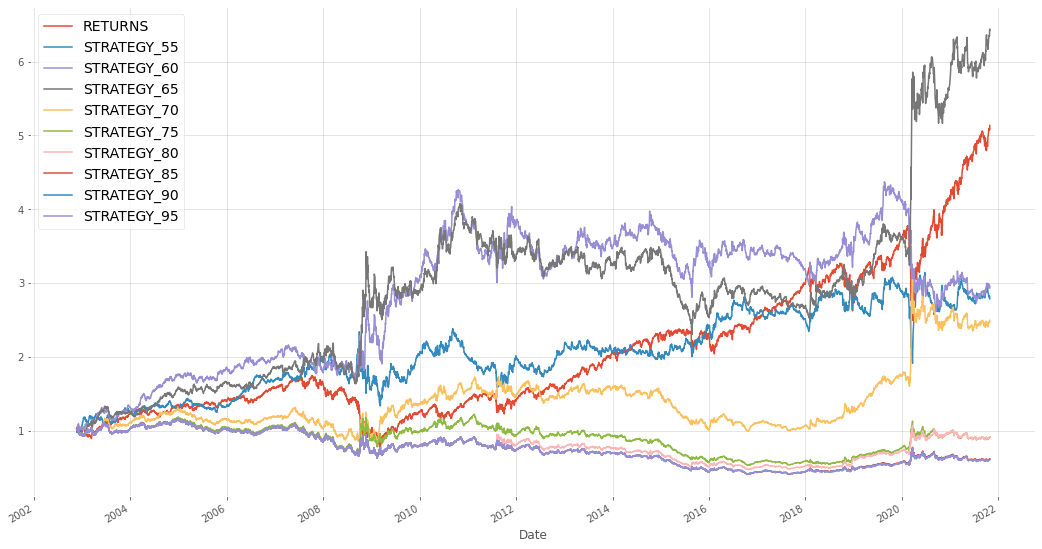

In [48]:
rsi_list = ['RETURNS']
rsi_exceed = []
for n in np.arange(55, 100, 5):
    position = 0
    positions = []
    for i in range(len(rsi.index)):
        if (rsi['RSI'][i] < 50) & (rsi['RSI'][i] > 100 - n):
            position = -1
        elif rsi['RSI'][i] < n:
            position = 1
        elif (rsi['RSI'][i] > 50) & (rsi['RSI'][i] < n):
            position = 1
        elif rsi['RSI'][i] > n:
            position = -1
        positions.append(position)
    rsi_list.append('STRATEGY_%d' % n)
    rsi['POSITION_%d' % n] = positions
    rsi['STRATEGY_%d' % n] = rsi['POSITION_%d' % n].shift(1) * rsi['RETURNS']
    rsi_exceed.append(rsi[['STRATEGY_%d' % n]].dropna().sum().apply(np.exp)[0] - rsi[['RETURNS']].dropna().sum().apply(np.exp)[0])
rsi[rsi_list].cumsum().apply(np.exp).plot(figsize = (18, 10))
plt.show()

In [49]:
print('Max Strategy is ', str(rsi_list[rsi_exceed.index(max(rsi_exceed)) + 1]), ' with excess return of ', str(max(rsi_exceed)))

Max Strategy is  STRATEGY_65  with excess return of  1.2930078682516664


In [50]:
rsi[rsi_list].dropna().sum().apply(np.exp)

RETURNS       5.038
STRATEGY_55   2.786
STRATEGY_60   2.933
STRATEGY_65   6.429
STRATEGY_70   2.495
STRATEGY_75   0.912
STRATEGY_80   0.916
STRATEGY_85   0.617
STRATEGY_90   0.608
STRATEGY_95   0.608
dtype: float64

##### Strategy of 55 overbought and 45 oversold (ONE DAY RETURN)

In [51]:
rsi['buy_or_sell'] = np.where(rsi['POSITION_65'] == 1.0, 
                       1, 0) 
rsi['SIGNAL'] = rsi['buy_or_sell'].diff()

rsi['SIGNAL'].value_counts()

0.000     3663
-1.000     553
1.000      552
Name: SIGNAL, dtype: int64

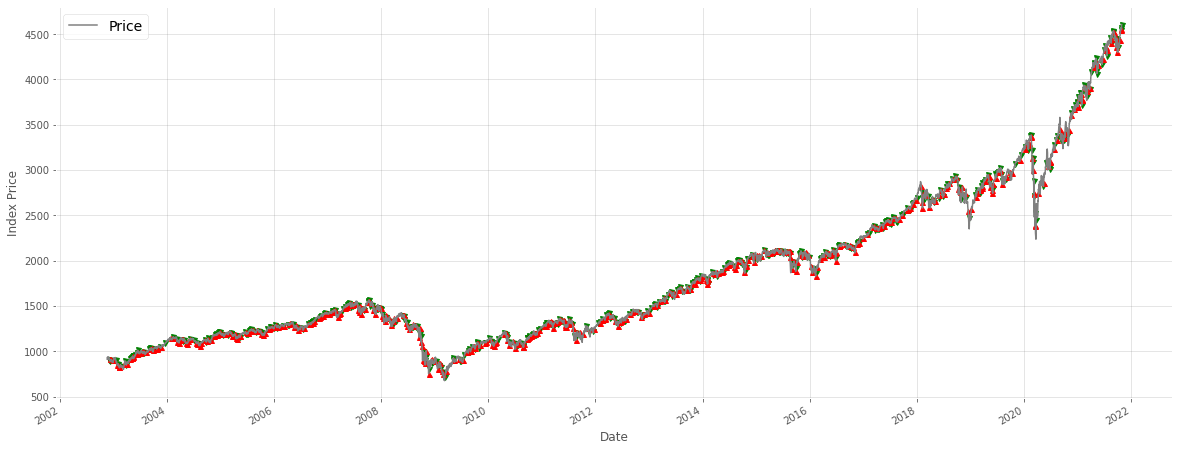

In [52]:
fig = plt.figure(figsize = (20, 8))

sub = fig.add_subplot(111, 
                     ylabel = 'Index Price')

sub.plot(rsi.loc[rsi['SIGNAL'] == -1].index, 
        rsi.Price[rsi['SIGNAL'] == -1], 
        'v', 
        markersize = 5,
        color = 'green')

sub.plot(rsi.loc[rsi['SIGNAL'] == 1].index, 
        rsi.Price[rsi['SIGNAL'] == 1], 
        '^', 
        markersize = 5 , 
        color = 'red')
rsi[['Price']].plot(ax = sub, 
                color = 'grey')
plt.show()

##### Backtesting

In [53]:
RSIposition = pd.DataFrame(index = rsi.index).fillna(0.0)
RSIposition['SP500'] = (capital // rsi['Price'][0]) * rsi['buy_or_sell']
RSIportfolio = RSIposition.multiply(rsi['Price'], 
                                             axis = 0)
diff_in_share_owned = RSIposition.diff()

RSIportfolio['holdings'] = (RSIposition.multiply(rsi['Price'], 
                                                           axis = 0)
                          ).sum(axis = 1)
RSIportfolio['cash'] = capital - (diff_in_share_owned.multiply(rsi['Price'], 
                                                                           axis = 0)).sum(axis = 1).cumsum()
RSIportfolio['total'] = RSIportfolio['holdings'] + RSIportfolio['cash']
RSIportfolio['returns'] = RSIportfolio['total'].pct_change()

RSIportfolio_final_value = RSIportfolio.total[-1]
print('Final Value of Capital is ', str(RSIportfolio_final_value))

Final Value of Capital is  2911055.286376953


In [ ]:
fig = plt.figure(figsize = (20, 8))
sub = fig.add_subplot(111, 
                     ylabel = 'Value of Portfolio')
sub.plot(RSIportfolio.loc[rsi['SIGNAL'] == -1].index, 
        RSIportfolio.total[rsi['SIGNAL'] == -1], 
        'v', 
        color = 'green', 
        markersize = 5)
sub.plot(RSIportfolio.loc[rsi['SIGNAL'] == 1].index, 
        RSIportfolio.total[rsi['SIGNAL'] == 1], 
        '^', 
        color = 'red', 
        markersize = 5)
RSIportfolio['total'].plot(ax = sub, 
                         color = 'grey')
plt.show()

In [54]:
Sharpe = np.sqrt(253) * (RSIportfolio['returns'].mean() / RSIportfolio['returns'].std())
Sharpe

0.7683339716090944

In [55]:
D = (RSIportfolio.index[-1] - RSIportfolio.index[0]).days

CAGR = (RSIportfolio[['returns']].sum().apply(np.exp) ** (365.0/D)) -1
CAGR

returns   0.061
dtype: float64